In [1]:
%matplotlib notebook 

import random,threading,os,sys,asyncio
from time import sleep
import pandas as pd
import numpy as np
import ipympl
from ipywidgets import interactive
import matplotlib.pyplot as plt
import threading

from OpenVisus import *

Starting OpenVisus C:\Python38\lib\site-packages\OpenVisus\__init__.py 3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=0, releaselevel='final', serial=0) ...


In [2]:
db=LoadDataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1')
logic_box=db.getLogicBox()
dims=[logic_box[1][I]-logic_box[0][I] for I in range(3)]

def ReadSlice(db,dir,offset,quality):
    if dir==0:
        data=db.read(x=[offset,offset+1], quality=quality)
        return data[:,:,0]
    elif dir==1:
        data=db.read(y=[offset,offset+1], quality=quality)
        return data[:,0,:]
    else:
        data=db.read(z=[offset,offset+1], quality=quality)
        return data[0,:,:]

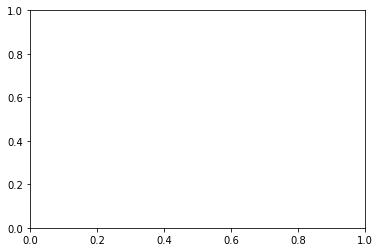

In [11]:
# ///////////////////////////////////////////////////////////////////
class PlotStatistics:
    
    # constructor
    def __init__(self):
        self.stats_thread=None
        self.stats_stop_thread=False

    # startStatistics
    def startStatistics(self,db=None,dir=0,quality=0,stats_plot=None, stats_image=None, background=True):
        
        if background:
            self.stats_stop_thread=False
            self.stats_thread=threading.Thread(target=self.startStatistics,args=(db,dir,quality,stats_plot, stats_image,False))
            self.stats_thread.start()     
            return
        
        logic_box=db.getLogicBox()
        dims=[logic_box[1][I]-logic_box[0][I] for I in range(3)]   
        N=dims[dir]
        
        x=list(range(N))
        y=[0]*N 
        
        last_data=None
        for offset in range(N):
            
            if self.stats_stop_thread:
                return
            
            sleep(0.05) # to tune!
            
            try:
                data=ReadSlice(db,dir,offset,quality)
                last_data=data
            except:
                data=last_data

            # count non zero pixels
            y[offset]=np.count_nonzero((data>80)*255)  
            
            if stats_plot:
                stats_plot.cla()
                stats_plot.plot(x,y,color="blue")
                
            if stats_image:
                stats_plot.cla()
                stats_plot.imshow(data, origin='lower',cmap='gray') 
            
            if stats_plot or stats_image:
                plt.draw()        
        
    # stopStatistics
    def stopStatistics(self):
        if self.stats_thread is None: return
        self.stats_stop_thread=True
        self.stats_thread.join()
        self.stats_thread=None
        

_, stats_axs = plt.subplots()
plt.show()        
        
plot=PlotStatistics()
plot.startStatistics(db,dir=0,quality=-15,stats_plot=stats_axs,stats_image=None)
# plot.stopStatistics()